<a href="https://colab.research.google.com/github/OlegPozovnoy/HW2AdvancedDL/blob/main/HW2AdvancedDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gym
## ура наконец доделал
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows, n_cols, n_win):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    # Возвратим лучше вектор
    def getVec(self):
        if self.boardHash is None:
            self.getHash()
        return tuple(self.board.reshape(self.n_rows * self.n_cols))

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def getStateVec(self):
        return (self.getVec(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [3]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
#             else:
#                 ax.text( a[1] , a[0] , "???", fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    #plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

In [4]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

Нолики выиграли!


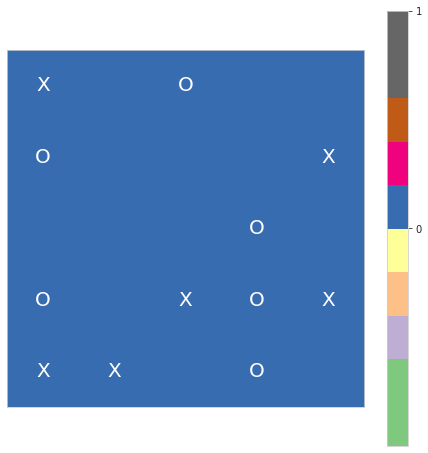

In [5]:
env = TicTacToe(n_rows=5, n_cols=5, n_win=3)
plot_test_game(env, None, None, random_crosses=True, random_naughts=True, verbose=True, fontx=20)

## Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

In [ ]:
np.random.seed(123)

class TickToeStrategy():
    def __init__(self, lr):
        self.Q = {}
        self.counter = {}
        self.lr = lr

    def updateQ(self, state, next_state, action, actions_num, reward, done):
        if state not in self.Q: 
            self.Q[state] = np.zeros(actions_num)
            self.counter[state] = np.zeros(actions_num)
            
        self.counter[state][action] += 1
        
        if not done and next_state in self.Q:
            nextQ = np.max(self.Q[next_state]) 
        else:
            nextQ = 0
        
        self.Q[state][action] += self.lr * (reward + nextQ - self.Q[state][action])
    
    def get_epsilon_greedy(self, state, actions_num, eps):
        if (np.random.random() < eps) or (state not in self.Q):
            return np.random.choice(actions_num)
        else:
            return np.argmax(self.Q[state])        

    def get_state(self, state):
        if state in self.Q:
            return self.Q[state]
        return None
    


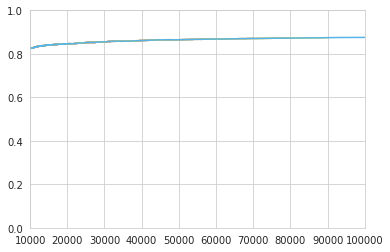

last_avg_reward 0.875


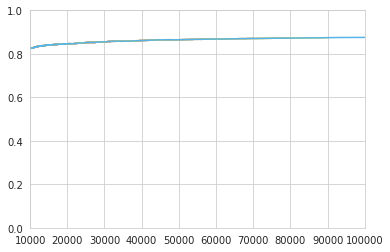

In [ ]:
import matplotlib.pyplot as plt
import time
import pylab as pl
from IPython import display


def conduct_experiment(strategy, eps = 0.1, num_iterations = 100000, plot = False, debug = False):
    print(f'начинаем эксперимент, lr = {strategy.lr} epsilon = {eps} num_iter = {num_iterations}')
    avg_rewards = []

    for _ in range(num_iterations):
        state = env.reset()    
        if debug: print("New Game")
        done = False
        
        while not done:
            state, actions = env.getVec(), env.getEmptySpaces()
            act_num = strategy.get_epsilon_greedy(state, len(actions), eps)

            if debug: print("state", state)
            if debug: print("action", actions[act_num])
            # делаем свой ход
            rewardWhite, rewardBlack = 0,0
            observation, rewardWhite, done, _ = env.step(actions[act_num])
            # делаем случайный ход соперника
            if not done:
                actions_next = env.getEmptySpaces()
                opp_move = np.random.randint(len(actions_next))
                observation, rewardBlack, done, _ = env.step(actions_next[opp_move])

            next_state = env.getVec()
            reward = rewardBlack + rewardWhite

            if debug: print("next_state", env.getVec(), rewardWhite + rewardBlack, done, strategy.get_state(next_state))
            if debug: print("old value", strategy.get_state(state), reward, np.max(strategy.get_state(state)))            


            strategy.updateQ(state, next_state, act_num,  len(actions), reward, done)

            if debug: print("new value", strategy.get_state(next_state))

            state = next_state
            if done:
                if len(avg_rewards) == 0:
                    avg_rewards.append(reward)
                else:
                    avg_rewards.append((avg_rewards[-1] * len(avg_rewards) + reward)/(len(avg_rewards)+1))

        if len(avg_rewards)%10000 == 0 and plot:
            pl.plot(avg_rewards)
            pl.xlim(10000, num_iterations)
            pl.ylim(0,1)
            display.clear_output(wait=True)
            display.display(pl.gcf())
    print(f'last_avg_reward {round(np.mean(avg_rewards[-10000:]),3)}')
    return avg_rewards, strategy.counter, strategy.Q
 
    
strategy = TickToeStrategy(0.01)  
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
avg_rewards, states_counter, q_values = conduct_experiment(strategy, eps = 0.1, num_iterations = 100000, debug = False, plot = True)

In [ ]:
#print(q_values)
#print(states_counter)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



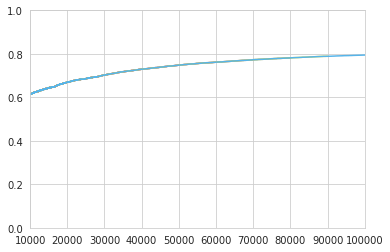

last_avg_reward 0.792


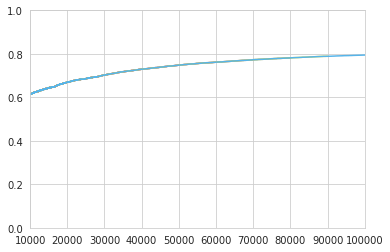

In [ ]:
strategy = TickToeStrategy(0.01)  
env = TicTacToe(n_rows=4, n_cols=4, n_win=3)
avg_rewards, states_counter, q_values = conduct_experiment(strategy, eps = 0.1, num_iterations = 100000, debug = False, plot = True)

In [ ]:
#print("Q", q_values)
#print("States", states_counter)

Q 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



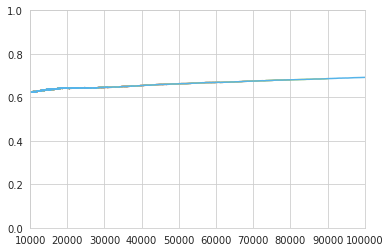

last_avg_reward 0.689


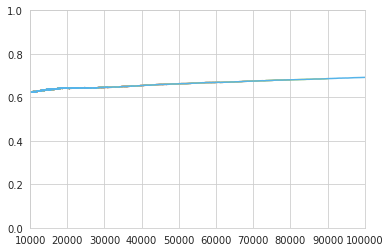

In [ ]:
strategy = TickToeStrategy(0.01)  
env = TicTacToe(n_rows=5, n_cols=5, n_win=3)
avg_rewards, states_counter, q_values = conduct_experiment(strategy, eps = 0.1, num_iterations = 100000, debug = False, plot = True)

In [ ]:
print("Q", q_values)
print("States", states_counter)

Q 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Часть вторая: добавим нейронных сетей
#### Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).
##### Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.
##### Реализуйте Double DQN и/или Dueling DQN.


реализуем DoubleDQN, он проще)

In [ ]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [ ]:
class Network(nn.Module):
    def __init__(self, n_rows, n_cols, layer_size=256):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(n_rows * n_cols, layer_size)
        self.l2 = nn.Linear(layer_size, n_rows * n_cols)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

In [ ]:
import random as rand

class TickTackDQN():
    def __init__(self, n_rows, n_cols, n_win):
        self.env = TicTacToe(n_rows, n_cols, n_win)
        
        self.modelA = Network(n_rows, n_cols)
        self.modelB = Network(n_rows, n_cols)
        self.optimizerA = optim.Adam(self.modelA.parameters(), 0.001)
        self.optimizerB = optim.Adam(self.modelB.parameters(), 0.001)
        self.model_state = rand.randrange(2)

        self.memory = ReplayMemory(10000)
        self.steps_done = 0
        self.episode_durations = []
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win
        
        self.gamma = 0.8
        self.batch_size = 64
        
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 200
        self.num_step = 0

    def get_active_model(self):
        return (self.modelA, self.modelB) if self.model_state == 0 else (self.modelB, self.modelA)

    def get_active_optimizer(self):
        return self.optimizerA if self.model_state == 0 else self.optimizerB

    def select_greedy_action(self, state):
        model, _ = self.get_active_model()
        return model(state).data.max(1)[1].view(1, 1)

    def select_action(self, state, actions):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state)
        else:
            action_num = random.randrange(len(actions))
            action_code = actions[action_num][0] * self.n_cols + actions[action_num][1]  
            return torch.tensor([[action_code]], dtype=torch.int64)

        
    def run_episode(self, e=0, do_learning=True, greedy=False, render=False, debug = False):
        self.env.reset()    
        if debug: print("New Game")
        done = False
        
        while not done:
            state, actions = self.env.getVec(), self.env.getEmptySpaces()
            state_tensor = torch.tensor([state], dtype=torch.float32)
            if debug: print("state_tensor", state_tensor)
            
            # делаем новую модель акттивной
            self.model_state = rand.randrange(2)
            
            with torch.no_grad():
                if greedy:
                    action = self.select_greedy_action(state_tensor)
                else:
                    action = self.select_action(state_tensor, actions)

            if debug: print("state", state)
            if debug: print("action", action.item())
            # делаем свой ход
            rewardWhite, rewardBlack = 0,0
            move = [(int)(action.item()/self.n_cols), action.item()%self.n_cols]
            if debug: print("move", move)
            observation, rewardWhite, done, _ = self.env.step(move)
            # делаем случайный ход соперника
            if not done:
                actions_next = self.env.getEmptySpaces()
                opp_move = np.random.randint(len(actions_next))
                observation, rewardBlack, done, _ = self.env.step(actions_next[opp_move])

            next_state = self.env.getVec()
            reward = rewardBlack + rewardWhite

            if debug: print("next_state", self.env.getVec(), rewardWhite + rewardBlack, done, strategy.get_state(next_state))
            if debug: print("old value", state, reward, action)            
            if debug: print("new value", next_state)
            
            next_state_tensor = torch.tensor([next_state], dtype=torch.float32)
            action_tensor = torch.tensor([[action]], dtype=torch.int64)   
            transition = (state_tensor, action_tensor, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
            self.memory.store(transition)

            if do_learning:
                self.learn()

            state = next_state       

    def learn(self):
        #print("Learn")
        if len(self.memory) < self.batch_size:
            return

        # берём мини-батч из памяти
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)
        
        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))

        # считаем значения функции Q
        model_act, model_back = self.get_active_model()

        Q = model_act(batch_state).gather(1, batch_action).reshape([self.batch_size])
       
        # оцениваем ожидаемые значения после этого действия
        Qmax = model_back(batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)
        #print("Qnext", Qnext)
        
        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)

        optimizer = self.get_active_optimizer()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [ ]:
import tqdm

pg = TickTackDQN(3,3,3)

n_iter = 10000
print(f"%s\tStarting training for {n_iter} episodes...{datetime.now().time()}")
for e in tqdm.tqdm(range(10000)):
    pg.run_episode(e, debug = False)

  0%|          | 30/10000 [00:00<00:33, 295.79it/s]

%s	Starting training for 10000 episodes...20:01:21.132162


100%|██████████| 10000/10000 [01:13<00:00, 135.36it/s]


In [ ]:
state = torch.tensor([1,-1,0,0,0,0,0,0,0], dtype=torch.float32)

print(pg.modelA(state))

# сделаем укороченную версию получения лучшего хода

def get_best_move(model, state, n_cols):
  model.eval()
  state = torch.tensor(state, dtype=torch.float32)
  index = torch.argmax(model(state).data)
  move = [(int)(index.item()/n_cols), index.item()%n_cols]
  return move

get_best_move(pg.modelA, [0,0,0,0,0,0,0,0,0],3)

tensor([ -9.5783, -10.4937,  -1.5892,  -1.4042,   0.4535,  -1.2763,   0.3544,
         -1.7668,   0.8541], grad_fn=<AddBackward0>)


[1, 1]

In [ ]:
import copy

def championship_match(env, model, n_cols, n_iter):
    wins = 0
    loses = 0
    draws = 0
    for _ in range(n_iter):
        env_copy = copy.deepcopy(env)  
        done = False
        while not done:
            state = env_copy.getVec()
            move = get_best_move(model, state, n_cols)
            observation, reward, done, _ = env_copy.step(move)  
            if done: break          
            actions = env_copy.getEmptySpaces()
            move = np.random.randint(len(actions))
            observation, reward, done, _ = env_copy.step(actions[move])
        
        if reward == 1:
          wins +=1
        elif reward == -1:
          loses += 1
        else:
          draws +=1
    #print("simul_game", env.getVec(), wins, draws, loses)
    return wins, draws, loses


env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
championship_match(env, pg.modelA, 3, 1000)

(963, 3, 34)

+965 =1 -34 что явно лучше Q-learning, сделаем то же для 4 на 4 и 5 на 5

In [ ]:
pg = TickTackDQN(4,4,3)

n_iter = 10000
print(f"%s\tStarting training for {n_iter} episodes...{datetime.now().time()}")
for e in tqdm.tqdm(range(10000)):
    pg.run_episode(e, debug = False)

  0%|          | 21/10000 [00:00<00:53, 187.95it/s]

%s	Starting training for 10000 episodes...20:45:45.152880


100%|██████████| 10000/10000 [01:22<00:00, 121.09it/s]


In [ ]:
get_best_move(pg.modelA, np.zeros(16),4)

[2, 1]

In [ ]:
env = TicTacToe(4, 4, 3)
championship_match(env, pg.modelA, 4, 1000)

(973, 2, 25)

+973 =2 -25

In [ ]:
pg = TickTackDQN(5,5,3)

n_iter = 10000
print(f"%s\tStarting training for {n_iter} episodes...{datetime.now().time()}")
for e in tqdm.tqdm(range(10000)):
    pg.run_episode(e, debug = False)

  0%|          | 17/10000 [00:00<01:02, 159.26it/s]

%s	Starting training for 10000 episodes...20:48:32.634142


100%|██████████| 10000/10000 [01:31<00:00, 109.33it/s]


In [ ]:
env = TicTacToe(5, 5, 3)
championship_match(env, pg.modelA, 5, 1000)

(994, 2, 4)

+994 -2 -4

5, 5, 3 практически решена

## Часть третья

###### расширим и углубим поиск Крестики-нолики -- это, конечно, далеко не го, и обычный альфа-бета поиск с отсечением здесь наверняка может работать идеально вплоть до довольно больших досок. 

###### Однако мы всё-таки для этого учебного задания будем реализовывать более практически релевантный метод MCTS -- заодно фактически получится и упражнение на многоруких бандитов. 

###### Реализуйте rollouts со случайной стратегией и 
(опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте). 

###### Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.

реализуем rollout для случайной стратегии и сыграем заодно 1000 случайных игр

In [10]:
import copy

def random_rollout(env, n_iter):
    wins, draws, loses = 0, 0, 0
    for _ in range(n_iter):
        env_copy = copy.deepcopy(env)  
        done = False
        while not done:
            actions = env_copy.getEmptySpaces()
            move = np.random.randint(len(actions))
            observation, reward, done, _ = env_copy.step(actions[move])
        
        if reward == 1:
          wins +=1
        elif reward == -1:
          loses += 1
        else:
          draws +=1
    return wins, draws, loses


env_mc = TicTacToe(n_rows=3, n_cols=3, n_win=3)
random_rollout(env_mc, 1000)

(618, 119, 263)

In [11]:
# map reward to wins draws loses
def map_reward(reward):
  if reward==1:
    return (1, 0, 0)
  elif reward == 0:
    return (0, 1, 0)
  else:
    return (0,0,1)

Напишем Монте-Карло со случ стратегией

In [16]:
import math
import tqdm

# здесь записываем все дерево перебора
def build_tree(env_mc, games_iter):
  tree = {}
  # получим хэш текущей позиции
  initial_position = env_mc.getVec()
  # ключ  - позиция
  tree[(initial_position, None)] = {}
  tree[(initial_position, None)]['stats'] = [0,0,0] # wins draws loses

  for _ in tqdm.tqdm(range(games_iter)):
    #print("next_iter")
    # дерево для обновления путей в корень
    path_to_root = []
    # каждый раз меняем т.к. меняется очередь хода.
    count_wins = True
    # для каждого узла все дети должны быть исследованы
    done = False
    env_mc_copy = copy.deepcopy(env_mc)
    actions = env_mc_copy.getEmptySpaces()
    
    current_position = initial_position
    last_action = None

    while len(tree[(current_position, last_action)].keys()) > 1 and done == False: # вершина исследована
      # выберем по статистике в какой из листьев идти дальше
      best_action = None
      best_stat = None
      for action in actions:
        action = tuple(action)
        # выбираем action по модели конечного автомата
        N = sum(tree[(current_position, last_action)]['stats'])
        ni = sum(tree[(current_position, last_action)][action])
        
        if count_wins:
          wr = tree[(current_position, last_action)][action][0] + tree[(current_position, last_action)][action][1]/2
        else:
          wr = tree[(current_position, last_action)][action][2] + tree[(current_position, last_action)][action][1]/2
        wr/= sum(tree[(current_position, last_action)][action])

        stat = wr + math.sqrt(2*N/ni)
        if best_stat is None or best_stat < stat:
          best_action = action
          best_stat = stat
      
      # делаем шаг в сторону best_acton
      path_to_root.append(((current_position, last_action), best_action))
      _ , reward, done, _ = env_mc_copy.step(best_action)  
      current_position, last_action = env_mc_copy.getVec(), best_action
      count_wins = not count_wins
      actions = env_mc_copy.getEmptySpaces()
    
    # дошли до места где надо генерировать новые пути
    if done:
        pass_simul_upward(path_to_root, map_reward(reward), tree)
    else:
      for action in actions:
        action = tuple(action)
        if action not in tree[(current_position, last_action)]:
          env_mc_copy2 = copy.deepcopy(env_mc_copy)  
          _ , reward, done, _ = env_mc_copy2.step(action)
          new_state = env_mc_copy2.getVec()
          statistics = map_reward(reward) if done else random_rollout(env_mc_copy2, 1) 
          tree[(new_state, action)] = {}
          tree[(new_state, action)]['stats'] = statistics

          tree[(current_position, last_action)]['stats'] = [sum(x) for x in zip(tree[(current_position, last_action)]['stats'],statistics)]
          tree[(current_position, last_action)][action] = statistics
          pass_simul_upward(path_to_root, statistics, tree) 
  return tree

# проталкиваем симулированную игру наверх
def pass_simul_upward(path_to_root, results, tree):
  wins, draws, loses = results
  for pos in path_to_root:
    tree[pos[0]]['stats'] = [sum(x) for x in zip(tree[pos[0]]['stats'],[wins, draws, loses])]
    tree[pos[0]][pos[1]] = [sum(x) for x in zip(tree[pos[0]][pos[1]],[wins, draws, loses])]

env_mc = TicTacToe(n_rows=3, n_cols=3, n_win=3)
games_iter = 100000
tree = build_tree(env_mc, games_iter)

100%|██████████| 100000/100000 [01:44<00:00, 957.36it/s]


In [17]:
def get_Q_from_mc_tree(tree):  
  # посчитаем симуляции агрегированные по позиции и из них сконструируем лучшие ходы 
  pos_tree = {}
  for key in tree.keys(): 
    if key not in pos_tree:
      for inner_key in tree[key]:
        if inner_key != 'stats':
          if key[0] not in pos_tree:
            pos_tree[key[0]] = {}
          if inner_key not in pos_tree[key[0]]:
            pos_tree[key[0]][inner_key] = np.zeros(3)
          pos_tree[key[0]][inner_key] += np.array(tree[key][inner_key])
  return pos_tree

pos_tree = get_Q_from_mc_tree(tree)

In [18]:
# получаем лучших ход в позиции
def get_tree_best_move(pos_tree, position):
  best_move = None
  best_eval = -1
  if position not in pos_tree: return None
  for key in pos_tree[position]:
    eval = (pos_tree[position][key][0] + pos_tree[position][key][1]/2)/np.sum(pos_tree[position][key])
    if eval > best_eval:
      best_eval = eval
      best_move = key
  return list(best_move)


print(get_tree_best_move(pos_tree, (0,0,0,0,0,0,0,0,0)))

[1, 1]


проведем чемпионат

In [20]:
import copy

def championship_match(env, pos_tree, n_iter):
    wins = 0
    loses = 0
    draws = 0
    for _ in range(n_iter):
        env_copy = copy.deepcopy(env)  
        done = False
        while not done:
            state = env_copy.getVec()
            move = get_tree_best_move(pos_tree, state)
            
            # если позиция ранее не встречалась - играем случайно
            if move is None:
              actions = env_copy.getEmptySpaces()
              move_idx = np.random.randint(len(actions))
              move = actions[move_idx]
            
            observation, reward, done, _ = env_copy.step(move)  
            if done: break          
            actions = env_copy.getEmptySpaces()
            move = np.random.randint(len(actions))
            observation, reward, done, _ = env_copy.step(actions[move])
        
        if reward == 1:
          wins +=1
        elif reward == -1:
          loses += 1
        else:
          draws +=1
    return wins, draws, loses

#  Посчитаем все заново чтобы продемонстрировать цикл
games_iter = 100000
env_mc = TicTacToe(n_rows=3, n_cols=3, n_win=3)
tree = build_tree(env_mc, games_iter)
pos_tree = get_Q_from_mc_tree(tree)
print(championship_match(env_mc, pos_tree, 1000))

100%|██████████| 100000/100000 [01:47<00:00, 933.94it/s]


(987, 13, 0)


+987 =13 - 0 даже лучше нейросетей. хотя подозреваю нейросети лучше будут в играх где больше вариантов ходов за счет обощающей способности, сделаем то же для 4 на 4 и 5 на 5. 

In [21]:
games_iter = 50000
env_mc = TicTacToe(n_rows=5, n_cols=5, n_win=3)
tree = build_tree(env_mc, games_iter)
pos_tree = get_Q_from_mc_tree(tree)
print(championship_match(env_mc, pos_tree, 1000))

100%|██████████| 50000/50000 [25:36<00:00, 32.55it/s]


(771, 0, 229)


5 на 5 уже сильно хуже +771 -229 видимо потому что было слишком много незнакомых позиций против случайной стратегии

In [22]:
games_iter = 50000
env_mc = TicTacToe(n_rows=4, n_cols=4, n_win=3)
tree = build_tree(env_mc, games_iter)
pos_tree = get_Q_from_mc_tree(tree)
print(championship_match(env_mc, pos_tree, 1000))

100%|██████████| 50000/50000 [08:10<00:00, 101.99it/s]


(958, 0, 42)


на 4 на 4 +958 - 42

Вообще возможно динамический расчет позиций с помощью мс подразумевался, но крестики нолики 5 на 5 слишком неглубокая игра и как раз получилась симуляция оценки начальной позиции где мы не можем просчитать игру до конца и как бы делаем rollouts там где не досчитали по ходу игры. И делать 1000 игр, по ходу каждой запускать расчет  каждого хода итераций на 100 может быть долго и глубины особо не добавит
